In [1]:
from ncpol2sdpa import*
import numpy as np
import math
import random
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

In [4]:
# Set Parameters
R=5
met=3
level = 1
T = 20
group = 2
trajectory = [2,2]
sum_traj = sum(trajectory)
nrmse=np.zeros([sum_traj*met,R])
beltaRange=np.arange(0.5, 0.91, 0.1)
beltaRange=[round(i,1) for i in beltaRange]
# Generate observations of multiple trajectories
data=pd.read_csv('FairOutput.csv',header=None)
Y=data.to_numpy()

In [3]:
# Decision Variables
G = generate_operators("G", n_vars=1, hermitian=True, commutative=False)[0]
Fdash = generate_operators("Fdash", n_vars=1, hermitian=True, commutative=False)[0]
z = generate_operators("z", n_vars=1, hermitian=True, commutative=True)[0]
m = generate_operators("m", n_vars=T+1, hermitian=True, commutative=False)
q = generate_operators("q", n_vars=T, hermitian=True, commutative=False)
p = generate_operators("p", n_vars=T, hermitian=True, commutative=True)
f = generate_operators("f", n_vars=T, hermitian=True, commutative=True)
# Constraints
ine1 = [f[i] - Fdash*m[i+1] - p[i] for i in range(T)]
ine2 = [-f[i] + Fdash*m[i+1] + p[i] for i in range(T)]
ine3 = [m[i+1] - G*m[i] - q[i] for i in range(T)]
ine4 = [-m[i+1] + G*m[i] + q[i] for i in range(T)]
ines_unfair = ine1+ine2+ine3+ine4
# Objective
obj_A = z + 1*sum(p[i]**2 for i in range(T)) # 1 is optimal for level 1
obj_B = z + 3*sum(p[i]**2 for i in range(T)) # 3 is optimal for level 1

In [ ]:
fit_df = pd.DataFrame(columns=['nrmse', 'group', 'trajectory','model type','belta'])
for belta in beltaRange:
    # Solve
    r=0
    while r < R: 
        
        traj1list=random.sample(range(T), int(T*(1-belta)))
        traj1=list(set([*range(T)]) - set(traj1list))
        traj2list=random.sample(traj1, int(T*(1-belta)))
        traj2=list(set([*range(T)]) - set(traj2list))
        gro1Remain=pd.DataFrame(list(zip(traj1,traj2)))
        length=[gro1Remain.shape[0]]*trajectory[0]+[T]*trajectory[1]

        # Constraints
        max1 = [z-1/trajectory[0]*sum(1/length[j]*sum((Y[t,j]-f[t])**2 for t in gro1Remain[j]) for j in range(0,trajectory[0])) ]
        max2 = [z-1/trajectory[1]*sum(1/length[j]*sum((Y[t,j]-f[t])**2 for t in range(T)) for j in range(trajectory[0],sum_traj))]
        max3 = [z-(Y[t,j]-f[t])**2 for j in range(0,trajectory[0]) for t in gro1Remain[j]]
        max4 = [z-(Y[t,j]-f[t])**2 for j in range(trajectory[0],sum_traj) for t in range(T)]
        ines_A = ine1+ine2+ine3+ine4+max1+max2
        ines_B = ine1+ine2+ine3+ine4+max3+max4

        # Objective
        sum_error=[(Y[t,j]-f[t])**2 for j in range(trajectory[0]) for t in gro1Remain[j] ] + [(Y[t,j]-f[t])**2 for j in range(trajectory[0],sum_traj) for t in range(T)]
        obj_unfair = sum(sum_error) + 5*sum(p[i]**2 for i in range(T)) # 5 is optimal for level 1


        # Solve the fair NCPO A
        sdp_A = SdpRelaxation(variables = flatten([G,Fdash,z,f,p,m,q]), verbose = 2)
        sdp_A.get_relaxation(level, objective=obj_A, inequalities=ines_A)
        sdp_A.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
        print(sdp_A.primal, sdp_A.dual, sdp_A.status)
        if (sdp_A.status == 'infeasible'): 
            continue
        
        # Solve the fair NCPO B
        sdp_B = SdpRelaxation(variables = flatten([G,Fdash,z,f,p,m,q]), verbose = 2)
        sdp_B.get_relaxation(level, objective=obj_B, inequalities=ines_B)
        sdp_B.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
        print(sdp_B.primal, sdp_B.dual, sdp_B.status)
        if (sdp_B.status == 'infeasible'): 
            continue

        # Solve the unfair NCPO
        sdp_unfair = SdpRelaxation(variables = flatten([G,Fdash,f,p,m,q]), verbose = 2)
        sdp_unfair.get_relaxation(level, objective=obj_unfair, inequalities=ines_unfair)
        sdp_unfair.solve(solver='sdpa', solverparameters={"executable":"sdpa_gmp","executable": "C:\\Users\\zhouq\\Documents\\sdpa7-windows\\sdpa.exe"})
        print(sdp_unfair.primal, sdp_unfair.dual, sdp_unfair.status)
        if (sdp_unfair.status == 'infeasible'): 
            continue
            
        # Calculate nrmse         
        mean_j=[np.mean([Y[t,j] for t in gro1Remain[j] ]) for j in range(trajectory[0])]+[np.mean([Y[t,j] for t in range(T)]) for j in range(trajectory[0],sum_traj)]
        error_gro1=[sum( (Y[t,j]-f[t])**2 for t in gro1Remain[j] ) for j in range(trajectory[0])]
        error_gro2=[sum( (Y[t,j]-f[t])**2 for t in range(T) ) for j in range(trajectory[0],sum_traj)]
        nrmse_A_gro1 = [math.sqrt(  sdp_A[error_gro1[j]] / sum((Y[t,j]-mean_j[j])**2 for t in gro1Remain[j]) /length[j] ) for j in range(trajectory[0])]
        nrmse_A_gro2 = [math.sqrt(  sdp_A[error_gro2[j-trajectory[0]]] / sum((Y[t,j]-mean_j[j])**2 for t in range(T)) /length[j]) for j in range(trajectory[0],sum_traj)]
        nrmse_B_gro1 = [math.sqrt(  sdp_B[error_gro1[j]] / sum((Y[t,j]-mean_j[j])**2 for t in gro1Remain[j]) /length[j]) for j in range(trajectory[0])]
        nrmse_B_gro2 = [math.sqrt(  sdp_B[error_gro2[j-trajectory[0]]] / sum((Y[t,j]-mean_j[j])**2 for t in range(T)) /length[j]) for j in range(trajectory[0],sum_traj)]
        nrmse_U_gro1 = [math.sqrt(  sdp_unfair[error_gro1[j]] / sum((Y[t,j]-mean_j[j])**2 for t in gro1Remain[j]) /length[j]) for j in range(trajectory[0])]
        nrmse_U_gro2 = [math.sqrt(  sdp_unfair[error_gro2[j-trajectory[0]]] / sum((Y[t,j]-mean_j[j])**2 for t in range(T)) /length[j]) for j in range(trajectory[0],sum_traj)]

        nrmse_ABU=nrmse_A_gro1+nrmse_A_gro2+nrmse_B_gro1+nrmse_B_gro2+nrmse_U_gro1+nrmse_U_gro2
        group_ABU=flatten([[0]*trajectory[0]+[1]*trajectory[1]]*met)
        traj_ABU=flatten([*range(sum_traj)]*met)
        type_ABU=['Fair A']*sum_traj+['Fair B']*sum_traj+['Unfair']*sum_traj
        belta_ABU=[belta]*met*sum_traj
        r_df={'nrmse':nrmse_ABU, 'group':group_ABU, 'trajectory':traj_ABU,'model type':type_ABU,'belta':belta_ABU}
        r_df=pd.DataFrame(r_df)
        fit_df=fit_df.append(r_df, ignore_index=True)

        r+=1



The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
3.522271457177829 3.5201528414121412 unknown
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 140/140 constraints...
4.578867333213624 4.056728523858785 infeasible
The problem has 41 commuting, 43 noncommuting Hermitian variables
Calculating block structure...
Estimated number of SDP variables: 3654
Generating moment matrix...
Reduced number of SDP variables: 3654654 (done: 100.03%, ETA 00:00:-0.0)
Processing 82/82 constraints...
3.6000604438874815 3.600060443887486 optimal
The problem has 41 commuting, 43 noncommuting Hermi

In [3]:
fit_df=pd.read_csv('CompareBelta0429.csv')
fit_df['belta']=fit_df['belta'].astype(str) 
for i in range(fit_df.shape[0]):
    if fit_df.loc[i,'model type']=="Fair A":
        fit_df.loc[i,'model type']='Subgroup-Fair'
    elif fit_df.loc[i,'model type']=="Fair B":
        fit_df.loc[i,'model type']='Instant-Fair'
fit_df

,nrmse,group,trajectory,model type,belta
0,3.284373,0,0,Subgroup-Fair,0.5
1,4.286779,0,1,Subgroup-Fair,0.5
2,1.869044,1,2,Subgroup-Fair,0.5
3,1.361230,1,3,Subgroup-Fair,0.5
4,3.453653,0,0,Instant-Fair,0.5
...,...,...,...,...,...
535,1.840679,1,3,Instant-Fair,0.9
536,3.272847,0,0,Unfair,0.9
537,3.780277,0,1,Unfair,0.9
538,2.455595,1,2,Unfair,0.9


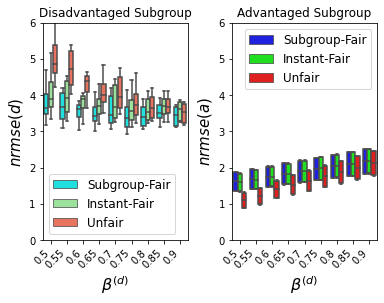

In [4]:
ax1=plt.subplot(1,2,1)
#fig, ax = plt.subplots()
fit_0=fit_df[fit_df['group']==0]
sns.boxplot(x="belta", y="nrmse", hue="model type", data=fit_0,palette=["cyan","lightgreen","tomato"]).set(xlabel=r'$\beta^{(d)}$',title='Disadvantaged Subgroup',ylabel='nrmse(d)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.ylim(0, 6)
plt.legend(fontsize=12)
plt.xlabel(r'$\beta^{(d)}$', fontsize=16)
plt.ylabel(r'$nrmse(d)$', fontsize=15)

ax2=plt.subplot(1,2,2)
#fig, ax = plt.subplots()
fit_1=fit_df[fit_df['group']==1]
sns.boxplot(x="belta", y="nrmse", hue="model type", data=fit_1,palette=["blue","lime","red"]).set(xlabel=r'$\beta^{(d)}$',title='Advantaged Subgroup',ylabel='nrmse(a)')#.set_title('Disadvantage Group')
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.ylim(0, 6)
plt.legend(fontsize=12)
plt.xlabel(r'$\beta^{(d)}$', fontsize=16)
plt.ylabel(r'$nrmse(a)$', fontsize=15)

plt.subplots_adjust(wspace=0.3)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Swtich to Type 42 Fonts.(A.K.A True Type)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.savefig('BoxPlot.pdf', bbox_inches='tight') 